In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
from addCombinedLimit import getCombinedR, CovarianceHandler
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts

## Get CheckMate Output

In [3]:
resultFolder = '../data/checkmate_BM2'
slhaFolder = '../data/slha_BM2'
recastDataByAna = {'cms_sus_16_048' : [],
              'cms_sus_16_025' : [],
              'atlas_conf_2016_054' : [],
              'atlas_susy_2018_04' : [],
              'cms_sus_19_005' : [], 'cms_sus_16_032' : []}
usedAnalyses = ['cms_sus_19_005','cms_sus_16_032']
recastData = []
for slhaFile in glob.glob(slhaFolder+'/*.slha'):
    slhaData = pyslha.readSLHAFile(slhaFile)
    mchi = slhaData.blocks['MASS'][5000521]
    mlsp = slhaData.blocks['MASS'][5000522]
    resDir = os.path.splitext(os.path.basename(slhaFile))[0]
    resFile = os.path.join(resultFolder,resDir,'evaluation',
                'total_results.txt')
    if not os.path.isfile(resFile):
        continue
    data = np.genfromtxt(resFile,names=True,
            dtype=None,encoding=None)
#     data = np.delete(data,np.where(data['sr'] == 'Combined')) #Exclude combination
    ibest = np.argmax(data['rexp'])
    bestAna = data['analysis'][ibest]    
    robs = data['robscons'][ibest]    
    if not bestAna in recastDataByAna:
        print(bestAna,'not in recastData')    
    for ana in recastDataByAna:
        dataAna = [pt for pt in data if pt['analysis'] == ana]
        ibestAna = np.argmax([pt['rexp'] for pt in dataAna])
        robsAna = [pt['robscons'] for pt in dataAna][ibestAna]
        recastDataByAna[ana].append([mchi,mlsp,robsAna])        
    if usedAnalyses != 'all':
        robs = 0.0
        for ana in usedAnalyses:
            robs = max(robs,recastDataByAna[ana][-1][-1])
    recastData.append([mchi,mlsp,robs])
        
for key,val in recastDataByAna.items():
    recastDataByAna[key] = np.array(val)
recastData = np.array(recastData)

In [18]:
kfactor = 1.5
contours = getContour(recastData[:,0],recastData[:,0]-recastData[:,1],kfactor*recastData[:,2],levels=[1.0])
contoursByAna = dict([[ana,getContour(recastD[:,0],recastD[:,0]-recastD[:,1],kfactor*recastD[:,2],levels=[1.0])] 
                      for ana,recastD in recastDataByAna.items()])

## Plot Curves

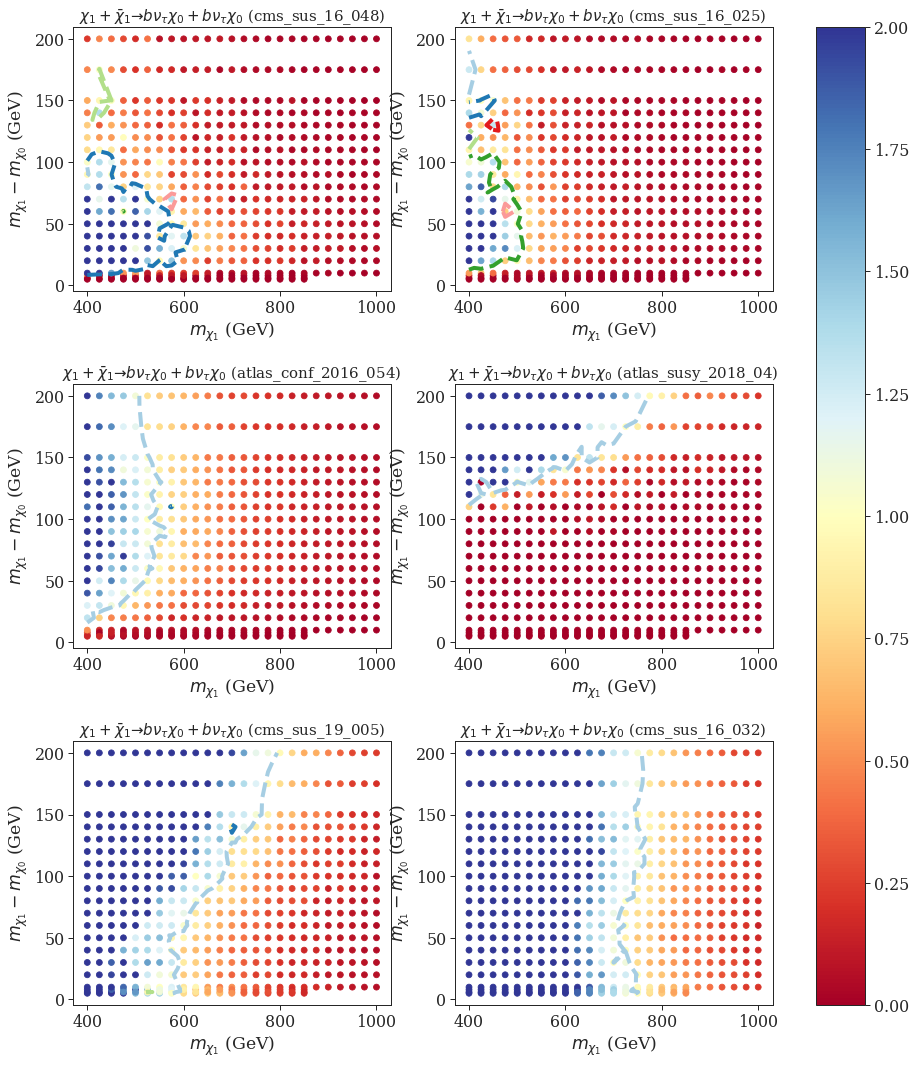

In [19]:
fig, axes = plt.subplots(nrows=int(len(recastDataByAna)/2.), ncols=2, figsize=(18,18))
irow = 0
icolumn = 0
for ana,rData in recastDataByAna.items():
    ax = axes[irow,icolumn]
    im = ax.scatter(rData[:,0],rData[:,0]-rData[:,1],c=kfactor*rData[:,2],
                    s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
    for level,curves in contoursByAna[ana].items():
        if level != 1.0: continue
        for i,curve in enumerate(curves):
            if i == 0:
                ax.plot(curve[:,0],curve[:,1],label=ana,
                    linestyle='--',linewidth=4)
            else:
                ax.plot(curve[:,0],curve[:,1],
                    linestyle='--',linewidth=4)
                
    ax.set_title(r"$\chi_1 + \bar{\chi}_1 \to b \nu_\tau \chi_0 + b \nu_\tau \chi_0$ (%s)" %ana,fontsize=15)
    ax.set_xlabel(r'$m_{\chi_1}$ (GeV)')    
    ax.set_ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
#     ax.legend()
    icolumn += 1
    if icolumn >= 2:
#         cb = fig.colorbar(im, ax=axes[irow,:].ravel().tolist())
        irow += 1 
        icolumn = 0
             
plt.subplots_adjust(hspace=0.35, wspace=0.2, right=0.8)
cb = fig.colorbar(im, ax=axes[:,:].ravel().tolist())
# plt.tight_layout()
# plt.savefig('TSbottom_exclusion_BM2.png')
plt.show()

In [20]:
#Curve from LH proceedings figure
monoJet = np.loadtxt('jets_plus_met_mchi1_vs_delta.csv',delimiter=',',skiprows=1)

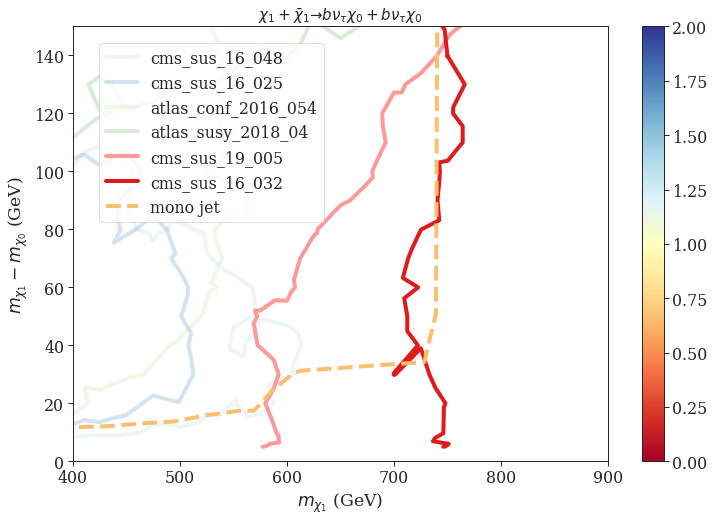

In [21]:
fig = plt.figure(figsize=(12,8))
for ana,c in contoursByAna.items():
    if not ana in usedAnalyses:
        alpha = 0.2
    else:
        alpha = 1.0
    for level,curves in c.items():
        if level != 1.0: continue
        for i,curve in enumerate(sorted(curves, key = lambda c: len(c),reverse=True)):
            if i == 0:
                plt.plot(curve[:,0],curve[:,1],label=ana,
                    linewidth=4,alpha=alpha)
            else:
                continue
                plt.plot(curve[:,0],curve[:,1],
                    linewidth=4,alpha=alpha)
plt.plot(monoJet[:,0],monoJet[:,1],linestyle='--',label='mono jet',linewidth=4)
plt.title(r"$\chi_1 + \bar{\chi}_1 \to b \nu_\tau \chi_0 + b \nu_\tau \chi_0$",fontsize=15)
plt.xlim(400.,900.)
plt.ylim(0,150.)
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
cb = fig.colorbar(im)
plt.legend(loc=(0.05,0.55))
plt.savefig('BM2_exclusionAll.png')
plt.show()

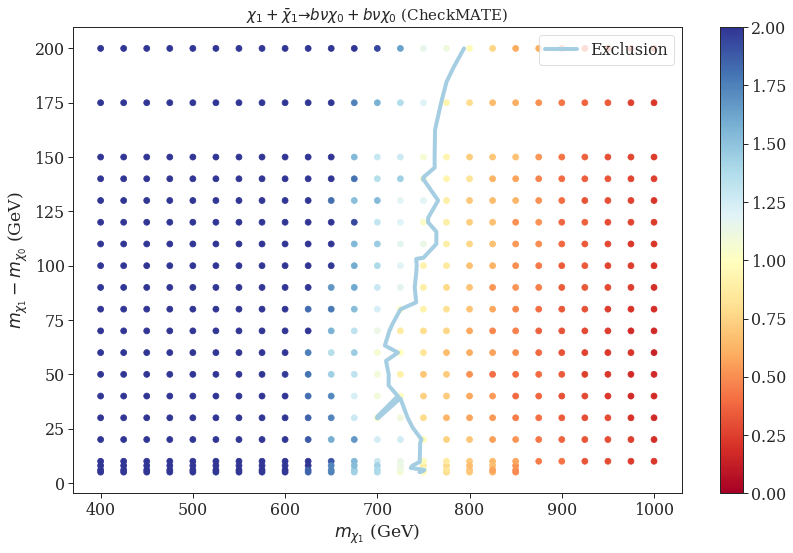

In [25]:
fig = plt.figure(figsize=(12,8))
cp = plt.scatter(recastData[:,0],recastData[:,0]-recastData[:,1],c=kfactor*recastData[:,2],
                    s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
   
excCurve =  sorted(contours[1.0], key = lambda pt: len(pt), reverse=True)[0]
plt.plot(excCurve[:,0],excCurve[:,1],label='Exclusion',
                linestyle='-',linewidth=4)
# plt.fill_between(excCurve[:,0],excCurve[:,1],(excCurve[:,0]-excCurve[:,1]).max(),alpha=0.5)
    
# plt.fill_between(excCurve[:,0],excCurve[:,1],excCurve[:,1].max(),alpha=0.5)
cb = plt.colorbar(cp)
# plt.yscale('log')
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
# plt.xlim(200.,1500.)
# plt.ylim(25,300.)
plt.legend()
plt.tight_layout()
plt.title(r"$\chi_1 + \bar{\chi}_1 \to b \nu \chi_0 + b \nu \chi_0$ (CheckMATE)",fontsize=15)
plt.tight_layout()
# plt.savefig('TSbottom_exclusion_BM2.png')
plt.show()

In [26]:
np.savetxt('exclusion_BM2.txt',excCurve,delimiter=',',header="mchi1 (GeV), mchi1-mchi0 (GeV)")

In [27]:
excCurve[:,1].min()

5.0